In [2]:
!pip install wandb


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.2/208.2 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.7/357.7 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 4.0 MB/s eta 0:00:00


In [3]:
import wandb
import torch
import os

from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt


In [4]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: lavkeshh17 (lavkeshh17-kk) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
import sys
#CHANGE WITH PATH OF model.py
sys.path.append("/content/model.py")  # 👈 replace with your actual folder name

from model import UNet


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# Step 1: Initialize W&B run
wandb.init(project="unet", entity="lavkeshh17-kk", job_type="inference")

In [8]:
# Step 2: Use the model artifact
artifact = wandb.use_artifact('lavkeshh17-kk/unet/unet_polygon_color:latest', type='model')
artifact_dir = artifact.download()

# Step 3: Check downloaded files
print("Artifact downloaded to:", artifact_dir)
print("Contents:", os.listdir(artifact_dir))

wandb: Downloading large artifact unet_polygon_color:latest, 118.49MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.9 (126.2MB/s)


Artifact downloaded to: /content/artifacts/unet_polygon_color:v1
Contents: ['unet_polygon_color.pth']


In [9]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate your model class
model = UNet().to(device)

# Load the state dict
model_path = os.path.join(artifact_dir, "unet_polygon_color.pth")
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

UNet(
  (downs): ModuleList(
    (0): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=T

In [10]:
transform = T.Compose([
    T.Resize((128, 128)),   # match your training size
    T.ToTensor()
])

def preprocess_image(img_path):
    img = Image.open(img_path).convert("RGB")
    return transform(img).unsqueeze(0).to(device)  # Add batch dimension


In [11]:
COLOR_MAP = {
    "red":     [1.0, 0.0, 0.0],
    "green":   [0.0, 1.0, 0.0],
    "blue":    [0.0, 0.0, 1.0],
    "yellow":  [1.0, 1.0, 0.0],
    "cyan":    [0.0, 1.0, 1.0],
    "magenta": [1.0, 0.0, 1.0],
    "white":   [1.0, 1.0, 1.0],
    "black":   [0.0, 0.0, 0.0],
    "orange":  [1.0, 0.5, 0.0],
    "purple":  [0.5, 0.0, 0.5]
}


In [12]:
def run_inference(img_path, color_name):
    # Check color validity
    if color_name.lower() not in COLOR_MAP:
        raise ValueError(f"Unsupported color '{color_name}'. Try: {list(COLOR_MAP.keys())}")

    # Load and preprocess image
    img = Image.open(img_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to(device)  # Shape: [1, 3, H, W]

    # Create color tensor of same H x W as image
    rgb = torch.tensor(COLOR_MAP[color_name.lower()]).view(1, 3, 1, 1).to(device)
    color_tensor = rgb.expand(-1, -1, input_tensor.shape[2], input_tensor.shape[3])  # [1, 3, H, W]

    # Concatenate image + color channels → [1, 6, H, W]
    model_input = torch.cat([input_tensor, color_tensor], dim=1)

    # Inference
    with torch.no_grad():
        output = model(model_input)

    # Convert output to image
    pred = output.squeeze().cpu().numpy().transpose(1, 2, 0)
    pred = (pred * 255).astype("uint8")

    # Display
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Input")

    plt.subplot(1, 2, 2)
    plt.imshow(pred)
    plt.title(f"Colored: {color_name}")
    plt.show()


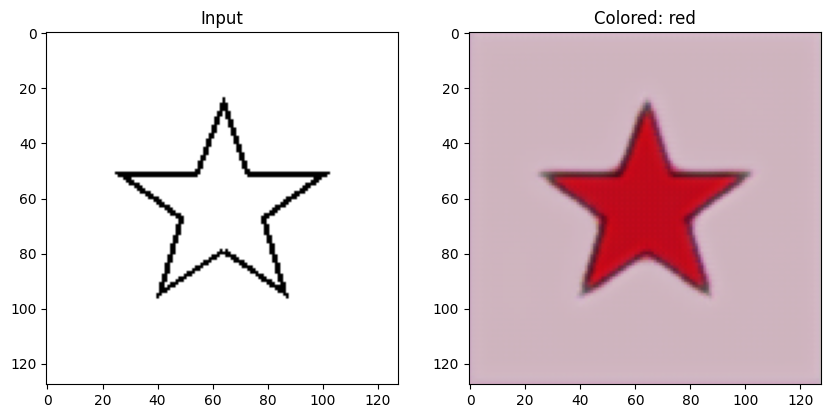

In [15]:
run_inference("//content/star.png", "red")
